# Plot for Zambia  cholera cases reported to WHO. 

   YearMonth  FluCases
0    2023-03       291
1    2023-04       381
2    2023-05       688
3    2023-06       756
4    2023-07       757
5    2023-08       757
6    2023-09       939
7    2023-10       961
8    2023-11      1759
9    2023-12      2659
10   2024-01     15589
11   2024-02     20176
12   2024-03     22217


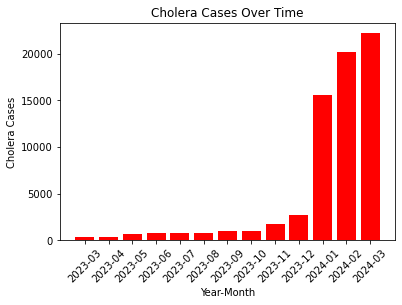

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Dates and corresponding Cholera cases 
dates = ["9 Mar 2023", "25 Apr 2023", "29 May 2023", "7 Jun 2023", "31 Jul 2023",
         "21 Aug 2023", "25 Sep 2023", "23 Oct 2023", "27 Nov 2023", "25 Dec 2023",
         "29 Jan 2024", "26 Feb 2024", "25 Mar 2024"]
Cholera_cases = [ 291,381, 688, 756, 757, 757, 939, 961, 1759, 2659, 15589, 20176, 22217]

# Convert date strings to datetime objects
dates = [datetime.strptime(date, "%d %b %Y") for date in dates]

# Create a DataFrame
Choleradata = pd.DataFrame({'Date': dates, 'FluCases': Cholera_cases})

# Extract year and month from the dates
Choleradata['YearMonth'] = Choleradata['Date'].dt.to_period('M')

# Group by YearMonth and sum the cholera cases for each month (in case of multiple entries per month)
monthly_data = Choleradata.groupby('YearMonth').sum().reset_index()

# Display the DataFrame (optional, for verification)
print(monthly_data)

# Plot the data as a bar chart
plt.bar(monthly_data['YearMonth'].astype(str), monthly_data['FluCases'], color='r')

# Labels and title
plt.xlabel('Year-Month')
plt.ylabel('Cholera Cases')
plt.title('Cholera Cases Over Time')

# Rotate date labels for better readability
plt.xticks(rotation=45)

# Show plot
#plt.show()

# Save the plot
plt.savefig('Zambia_cholera_Cases_in_WHO_AFRO_Region_9_Mar_2023_to_25_Mar_2024.png', facecolor='w')


#  Fitted model to actual data.

/usr/lib/python3/dist-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


sigma:0.019027976457235946,theta_h:0.08868947739575793,theta_e:0.05479866084983293, epsilon:0.027175362133554693,omega:0.00012021867374392852,r1:0.3006725563820228,k:1000000.0,psi:0.3137292870148979,m:0.09977752826070263
Convergence status: True


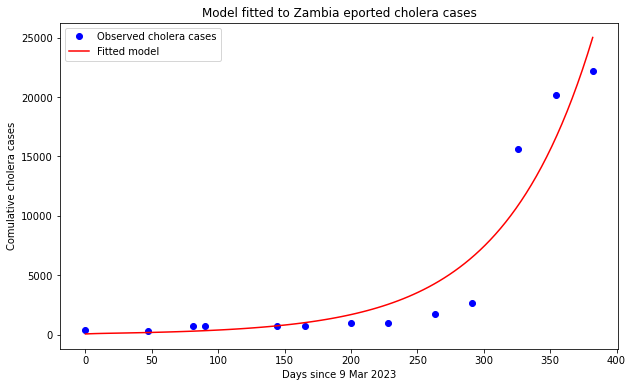

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
from datetime import datetime

# Convert dates to numerical format
dates = ["9 Mar 2023", "25 Apr 2023", "29 May 2023", "7 Jun 2023", "31 Jul 2023", "21 Aug 2023", "25 Sep 2023", "23 Oct 2023", "27 Nov 2023", "25 Dec 2023", "29 Jan 2024", "26 Feb 2024", "25 Mar 2024"]
dates = [datetime.strptime(date, "%d %b %Y") for date in dates]
dates = np.array([(date - dates[0]).days for date in dates])
cholera_cases = np.array([  381,291,688, 756, 757, 757, 939, 961, 1759, 2659, 15589, 20176, 22217])

# Differential equations
def cholera_model(y, t, sigma, theta_h, theta_e, epsilon, nu, iota, omega, r1, k, psi, m):
    s, i, r, b = y
    dsdt = sigma - (theta_h * i / (m + i) + theta_e * b) * s - (epsilon + sigma) * s
    didt = (theta_h * i / (m + i) + theta_e * b) * s - (sigma + nu + iota + omega) * i
    drdt = iota * i + epsilon * s - sigma * r
    dbdt = omega * i + r1 * b - (r1 * b**2 / k) - psi * b
    return [dsdt, didt, drdt, dbdt]

# Cost function to minimize
def cost_function(params, t, data):
    sigma, theta_h, theta_e, epsilon, nu, iota, omega, r1, k, psi, m = params
    y0 = [1e6  ,291,0, 0] 
    y0 = [60 ,50, 0, 0]  # Initial conditions
    sol = odeint(cholera_model, y0, t, args=(sigma, theta_h, theta_e, epsilon, nu, iota, omega, r1, k, psi, m))
    i_sol = sol[:, 1]
    return np.sum((i_sol - data)**2)

# Initial parameter guess
initial_guess = [ 0.03 ,0.08695,0.054764215,0.03,0.001, 0.0029,0.0006,0.3,1000000,0.3144,0.1]
#initial_guess = [ 0.03 ,0.08695,0.054764215,0.03,0.001, 0.0039,0.0006,0.3,1000000,0.3144,0.1]

#initial_guess = [ 0.002 ,0.08695,0.054764215,0.03,0.001, 0.0029,0.0006,0.3,1000000,0.3144,0.1]

# Optimization
result = minimize(cost_function, initial_guess, args=(dates, cholera_cases), method='L-BFGS-B')
optimized_params = result.x
sigma, theta_h, theta_e, epsilon, nu, iota, omega, r1, k, psi, m = optimized_params
print(f'sigma:{sigma},theta_h:{theta_h},theta_e:{theta_e}, epsilon:{ epsilon},omega:{omega},r1:{r1},k:{k},psi:{psi},m:{m}')
#print(f'sigma:{sigma},theta_h:{theta_h},theta_e:{theta_e}, epsilon:{ epsilon}, nu:{ nu},iota:{iota},omega:{omega},r1:{r1},k:{k},psi:{psi},m:{m}')
#print("Optimized parameters:", optimized_params)
print("Convergence status:", result .success)
# Solving the differential equations with optimized parameters
#y0 = [1e6  ,291,0, 0] 
y0 = [60  ,50,0, 0]  # Initial conditions
sol = odeint(cholera_model, y0, np.linspace(0, dates[-1], 100), args=tuple(optimized_params))

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(dates, cholera_cases, 'bo', label='Observed cholera cases')
plt.plot(np.linspace(0, dates[-1], 100), sol[:, 1], 'r-', label='Fitted model')
plt.title('Model fitted to Zambia eported cholera cases')
plt.xlabel('Days since 9 Mar 2023')
plt.ylabel('Comulative cholera cases')

plt.legend()
plt.show()
#plt.savefig('Model fitted to Zambia eported cholera cases', facecolor='w')

# Code for plotting behaviour of each compartments.

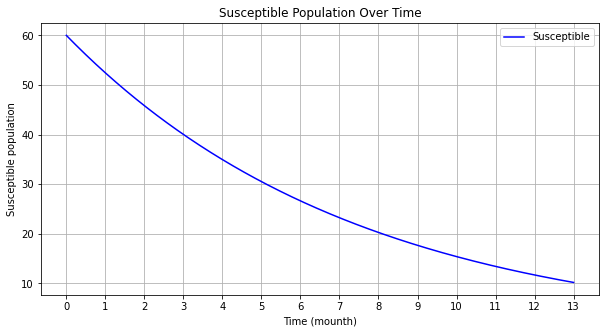

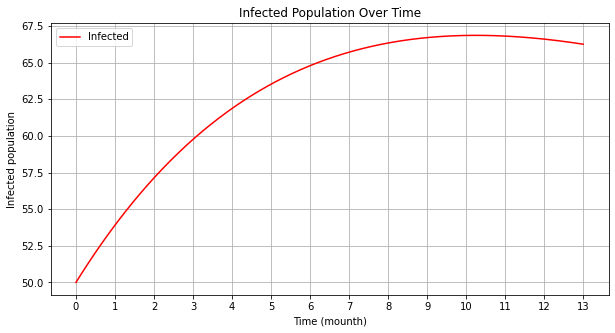

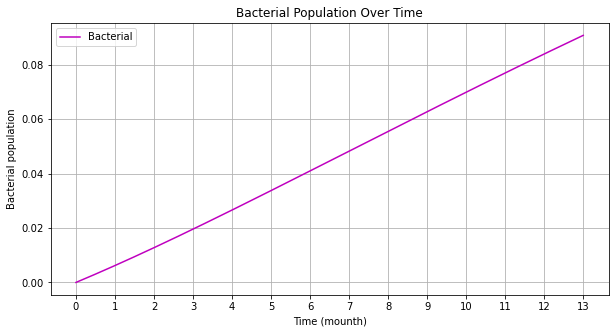

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Define the system of differential equations
def model(y, t, sigma, theta_h, theta_e, epsilon, nu, iota, omega, r1, k, psi, m):
    s, i, r, b = y
    dsdt = sigma - (theta_h * i / (m + i) + theta_e * b) * s - (epsilon + sigma) * s
    didt = (theta_h * i / (m + i) + theta_e * b) * s - (sigma + nu + iota + omega) * i
    drdt = iota * i + epsilon * s - sigma * r
    dbdt = omega * i + r1 * b - (r1 * b**2 )/ k - psi * b
    return [dsdt, didt, drdt, dbdt]

# Initial conditions
s0 = 60
i0 = 50
r0 = 0
b0 = 0
y0 = [s0, i0, r0, b0]

# Time points
t = np.linspace(0, 13, 500)


# Parameters
sigma = 0.019027976457235946
theta_h = 0.08868947739575793
theta_e = 0.05479866084983293
epsilon = 0.027175362133554693
omega = 0.00012021867374392852
r1 = 0.3006725563820228
psi = 0.3137292870148979
m = 0.09977752826070263
iota = 0.000116620
nu = 0.00132473
k = 1000000.0
# Solve ODE
solution = odeint(model, y0, t, args=(sigma, theta_h, theta_e, epsilon, nu, iota, omega, r1, k, psi, m))
s, i, r, b = solution.T

# # Plot Susceptible population
plt.figure(figsize=(10, 5))
plt.plot(t, s, 'b-', label='Susceptible')
plt.xlabel('Time (mounth)')
plt.ylabel('Susceptible population')
plt.legend()
plt.title('Susceptible Population Over Time')
plt.grid(True)
plt.xticks(ticks=np.arange(0,14), labels=np.round(np.arange(0,14), 0))
# plt.savefig('Susceptible Population', facecolor='w')
# Plot Infected population
plt.figure(figsize=(10, 5))
plt.plot(t, i, 'r-', label='Infected')
plt.xlabel('Time (mounth)')
plt.ylabel('Infected population')
plt.legend()
plt.title('Infected Population Over Time')
plt.grid(True)
plt.xticks(ticks=np.arange(0,14), labels=np.round(np.arange(0,14), 0))
# plt.savefig('Infected Population', facecolor='w')
plt.show()


# Plot Bacterial population
plt.figure(figsize=(10, 5))
plt.plot(t, b, 'm-', label='Bacterial')
plt.xlabel('Time (mounth)')
plt.ylabel('Bacterial population')
plt.legend()
plt.title('Bacterial Population Over Time')
plt.grid(True)
plt.xticks(ticks=np.arange(0,14), labels=np.round(np.arange(0,14), 0))
#plt.savefig('Bacterial Population', facecolor='w')

plt.show()

#plt.show()



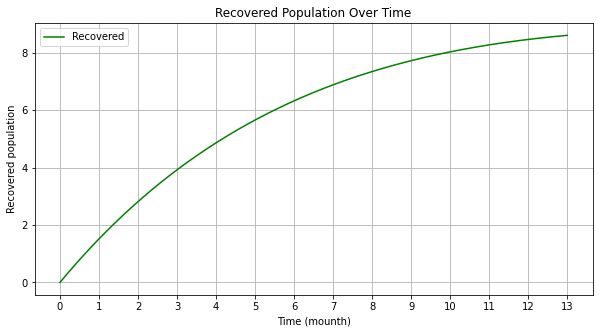

In [4]:
#Plot Recovered population
plt.figure(figsize=(10, 5))
plt.plot(t, r, 'g-', label='Recovered')
plt.xlabel('Time (mounth)') 
plt.ylabel('Recovered population')
plt.legend()
plt.title('Recovered Population Over Time')
plt.xticks(ticks=np.arange(0,14), labels=np.round(np.arange(0,14), 0))
plt.grid(True)
plt.savefig('Recovered0', facecolor='w')

#plt.show()


#  Plots of parameters variation in each compartments.

# For susceptible populations.

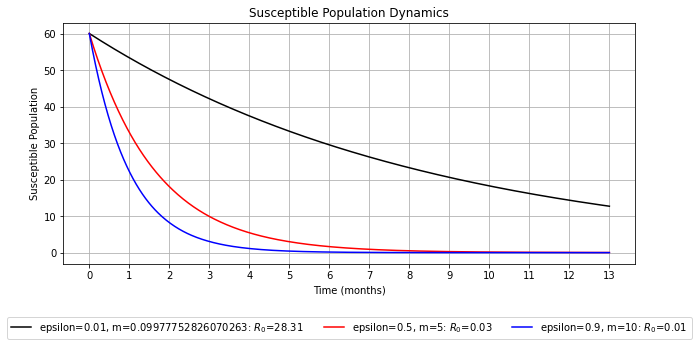

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Define the system of differential equations
def model(t, y, sigma, theta_h, theta_e, epsilon, nu, iota, omega, r1, k, psi, m):
    s, i, r, b = y
    dsdt = sigma - (theta_h * i / (m + i) + theta_e * b) * s - (epsilon + sigma) * s
    didt = (theta_h * i / (m + i) + theta_e * b) * s - (sigma + nu + iota + omega) * i
    drdt = iota * i + epsilon * s - sigma * r
    dbdt = omega * i + r1 * b - (r1 * b**2 / k) - psi * b
    return [dsdt, didt, drdt, dbdt]

# Initial conditions
s0 = 60
i0 = 50
r0 = 0
b0 = 0
initial_conditions = [s0, i0, r0, b0]

# Parameters
sigma = 0.019027976457235946
theta_h = 0.08868947739575793
theta_e = 0.05479866084983293
epsilon = 0.027175362133554693
omega = 0.00012021867374392852
r1 = 0.3006725563820228
psi = 0.3137292870148979
m = 0.09977752826070263
iota = 0.000116620
nu = 0.00132473
k = 1000000.0

# Define the function to calculate R_0
def calculate_R0(sigma, theta_h, theta_e, epsilon, nu, iota, omega, r1, psi, m):
    R_0 = (omega * theta_e * sigma) / ((nu + iota + omega + sigma) * (epsilon + sigma) * (psi - r1)) + \
          (theta_h * sigma) / ((nu + iota + omega + sigma) * (epsilon + sigma) * m)
    return R_0

R_0 = calculate_R0(sigma, theta_h, theta_e, epsilon, nu, iota, omega, r1, psi, m)

# Time span for the simulation
t_span = (0, 13)
t_eval = np.linspace(*t_span, 500)

# Function to solve the model and plot the results for susceptible population
def plot_susceptible_variation(param_name1, param_values1, param_name2, param_values2):
    fig, ax = plt.subplots(figsize=(10, 5))
    colors = ['black', 'red','blue' ]  # Define colors for different parameter values

    for param_value1, param_value2, color in zip(param_values1, param_values2, colors):
        params = [sigma, theta_h, theta_e, epsilon, nu, iota, omega, r1, k, psi, m]
        
        param_index1 = ['sigma', 'theta_h', 'theta_e', 'epsilon', 'nu', 'iota', 'omega', 'r1', 'k', 'psi', 'm'].index(param_name1)
        param_index2 = ['sigma', 'theta_h', 'theta_e', 'epsilon', 'nu', 'iota', 'omega', 'r1', 'k', 'psi', 'm'].index(param_name2)
        
        params[param_index1] = param_value1
        params[param_index2] = param_value2
        
        partial_params = params.copy()
        partial_params.pop(8)
        
        R_0 = calculate_R0(*partial_params)
        sol = solve_ivp(model, t_span, initial_conditions, t_eval=t_eval, args=tuple(params))
        
        label = f'{param_name1}={param_value1}, {param_name2}={param_value2}: $R_0$={np.round(R_0, 2)}'
        ax.plot(sol.t, sol.y[0], label=label, color=color)  # sol.y[0] is for susceptible population
    
    ax.set_xlabel('Time (months)')
    ax.set_ylabel('Susceptible Population')
    ax.set_title('Susceptible Population Dynamics')
    ax.legend(bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=len(param_values1))
    plt.grid(True)
    plt.xticks(ticks=np.arange(0,14), labels=np.round(np.arange(0,14), 0))
    plt.tight_layout()
    plt.show()

epsilon_values = [0.01, 0.5, 0.9]
m_values = [0.09977752826070263, 5, 10]
plot_susceptible_variation('epsilon', epsilon_values, 'm', m_values)
#plt.savefig('susceptibleE', facecolor='w')


# Infected compartments

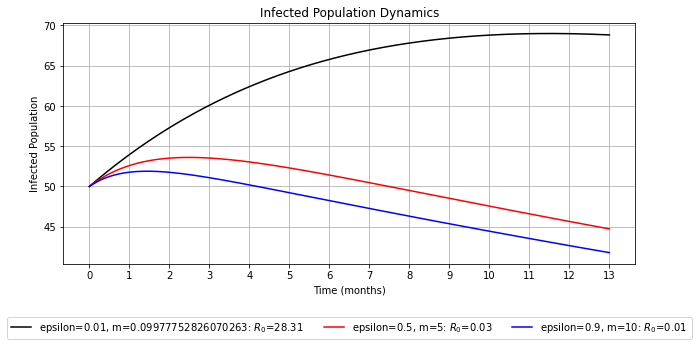

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Define the system of differential equations
def model(t, y, sigma, theta_h, theta_e, epsilon, nu, iota, omega, r1, k, psi, m):
    s, i, r, b = y
    dsdt = sigma - (theta_h * i / (m + i) + theta_e * b) * s - (epsilon + sigma) * s
    didt = (theta_h * i / (m + i) + theta_e * b) * s - (sigma + nu + iota + omega) * i
    drdt = iota * i + epsilon * s - sigma * r
    dbdt = omega * i + r1 * b - (r1 * b**2 / k) - psi * b
    return [dsdt, didt, drdt, dbdt]

# Initial conditions
s0 = 60
i0 = 50
r0 = 0
b0 = 0
initial_conditions = [s0, i0, r0, b0]


# Parameters
sigma = 0.019027976457235946
theta_h = 0.08868947739575793
theta_e = 0.05479866084983293
epsilon = 0.027175362133554693
omega = 0.00012021867374392852
r1 = 0.3006725563820228
psi = 0.3137292870148979
m = 0.09977752826070263
iota = 0.000116620
nu = 0.00132473
k = 1000000.0
# Define the function to calculate R_0
def calculate_R0(sigma, theta_h, theta_e, epsilon, nu, iota, omega, r1, psi, m):
    R_0 = (omega * theta_e * sigma) / ((nu + iota + omega + sigma) * (epsilon + sigma) * (psi - r1)) + \
          (theta_h * sigma) / ((nu + iota + omega + sigma) * (epsilon + sigma) * m)
    return R_0

R_0 = calculate_R0(sigma, theta_h, theta_e, epsilon, nu, iota, omega, r1, psi, m)

# Time span for the simulation
t_span = (0, 13)
t_eval = np.linspace(*t_span, 500)

# Function to solve the model and plot the results for infected population
def plot_infected_variation(param_name1, param_values1, param_name2, param_values2):
    fig, ax = plt.subplots(figsize=(10, 5))
    colors = ['black','red', 'blue']
    
    for param_value1, param_value2, color in zip(param_values1, param_values2, colors):
        params = [sigma, theta_h, theta_e, epsilon, nu, iota, omega, r1, k, psi, m]
        
        param_index1 = ['sigma', 'theta_h', 'theta_e', 'epsilon', 'nu', 'iota', 'omega', 'r1', 'k', 'psi', 'm'].index(param_name1)
        param_index2 = ['sigma', 'theta_h', 'theta_e', 'epsilon', 'nu', 'iota', 'omega', 'r1', 'k', 'psi', 'm'].index(param_name2)
        
        params[param_index1] = param_value1
        params[param_index2] = param_value2
        
        partial_params = params.copy()
        partial_params.pop(8)
        
        R_0 = calculate_R0(*partial_params)
        sol = solve_ivp(model, t_span, initial_conditions, t_eval=t_eval, args=tuple(params))
        
        label = f'{param_name1}={param_value1}, {param_name2}={param_value2}: $R_0$={np.round(R_0, 2)}'
        ax.plot(sol.t, sol.y[1], label=label, color=color)  # sol.y[1] is for infected population
    
    ax.set_xlabel('Time (months)')
    ax.set_ylabel('Infected Population')
    ax.set_title('Infected Population Dynamics')
    #ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.legend(bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=len(param_values1))

    plt.grid(True)
    plt.tight_layout()
    plt.xticks(ticks=np.arange(0,14), labels=np.round(np.arange(0,14), 0))

    plt.show()
   
epsilon_values = [ 0.01,0.5,0.9]
m_values = [0.09977752826070263,5,10]
plot_infected_variation('epsilon', epsilon_values,'m', m_values)
theta_h_values = [ 0.08868947739575793,0.09]
#plt.savefig('InfectedE', facecolor='w')


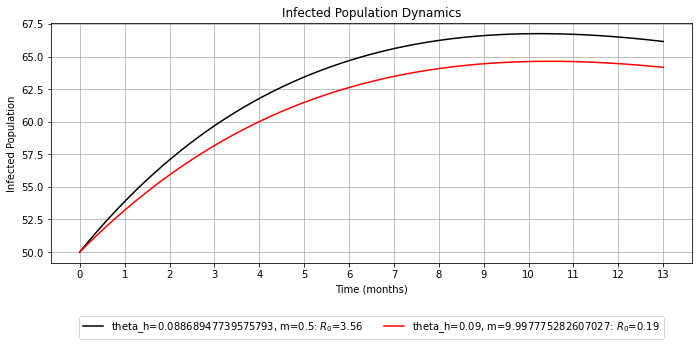

In [7]:
m_values = [0.5,9.9977752826070263]
plot_infected_variation('theta_h', theta_h_values,'m', m_values)
#plt.savefig('InfeE1', facecolor='w')

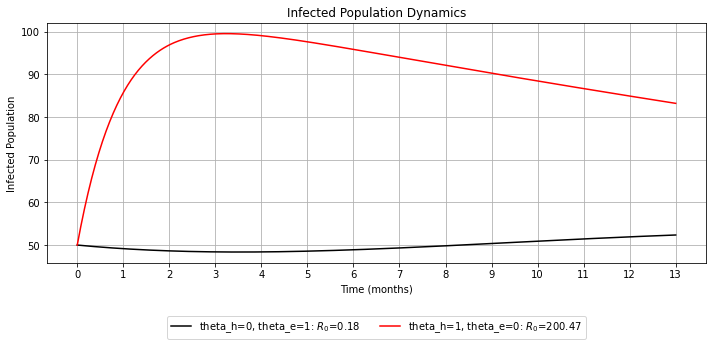

<Figure size 432x288 with 0 Axes>

In [8]:
theta_h_values = [0,  1]
theta_e_values = [1,  0]
plot_infected_variation('theta_h', theta_h_values, 'theta_e', theta_e_values)
plt.savefig('InfeE', facecolor='w')

#  For bacteria compartments .

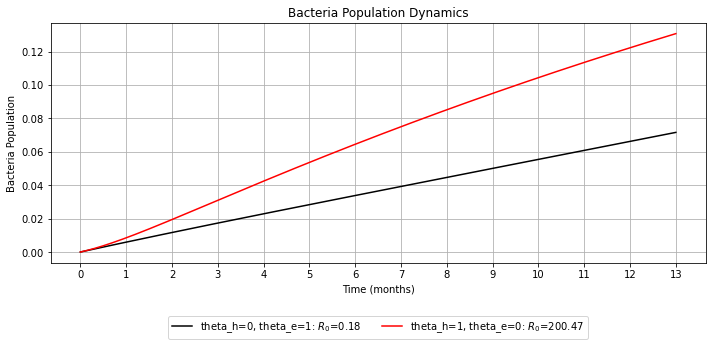

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Define the system of differential equations
def model(t, y, sigma, theta_h, theta_e, epsilon, nu, iota, omega, r1, k, psi, m):
    s, i, r, b = y
    dsdt = sigma - (theta_h * i / (m + i) + theta_e * b) * s - (epsilon + sigma) * s
    didt = (theta_h * i / (m + i) + theta_e * b) * s - (sigma + nu + iota + omega) * i
    drdt = iota * i + epsilon * s - sigma * r
    dbdt = omega * i + r1 * b - (r1 * b**2 / k) - psi * b
    return [dsdt, didt, drdt, dbdt]

# Initial conditions
s0 = 60
i0 = 50
r0 = 0
b0 = 0
initial_conditions = [s0, i0, r0, b0]

# Parameters
sigma = 0.019027976457235946
theta_h = 0.08868947739575793
theta_e = 0.05479866084983293
epsilon = 0.027175362133554693
omega = 0.00012021867374392852
r1 = 0.3006725563820228
psi = 0.3137292870148979
m = 0.09977752826070263
iota = 0.000116620
nu = 0.00132473
k = 1000000.0

# Define the function to calculate R_0
def calculate_R0(sigma, theta_h, theta_e, epsilon, nu, iota, omega, r1, psi, m):
    R_0 = (omega * theta_e * sigma) / ((nu + iota + omega + sigma) * (epsilon + sigma) * (psi - r1)) + \
          (theta_h * sigma) / ((nu + iota + omega + sigma) * (epsilon + sigma) * m)
    return R_0

R_0 = calculate_R0(sigma, theta_h, theta_e, epsilon, nu, iota, omega, r1, psi, m)

# Time span for the simulation
t_span = (0, 13)
t_eval = np.linspace(*t_span, 500)

# Function to solve the model and plot the results for bacteria population
def plot_bacteria_variation(param_name1, param_values1, param_name2, param_values2):
    fig, ax = plt.subplots(figsize=(10, 5))
    colors = ['black','red', 'blue']
    
    for param_value1, param_value2, color in zip(param_values1, param_values2, colors):
        params = [sigma, theta_h, theta_e, epsilon, nu, iota, omega, r1, k, psi, m]
        
        param_index1 = ['sigma', 'theta_h', 'theta_e', 'epsilon', 'nu', 'iota', 'omega', 'r1', 'k', 'psi', 'm'].index(param_name1)
        param_index2 = ['sigma', 'theta_h', 'theta_e', 'epsilon', 'nu', 'iota', 'omega', 'r1', 'k', 'psi', 'm'].index(param_name2)
        
        params[param_index1] = param_value1
        params[param_index2] = param_value2
        
        partial_params = params.copy()
        partial_params.pop(8)
        
        R_0 = calculate_R0(*partial_params)
        sol = solve_ivp(model, t_span, initial_conditions, t_eval=t_eval, args=tuple(params))
        
        label = f'{param_name1}={param_value1}, {param_name2}={param_value2}: $R_0$={np.round(R_0, 2)}'
        ax.plot(sol.t, sol.y[3], label=label, color=color)  # sol.y[3] is for bacteria population
    
    ax.set_xlabel('Time (months)')
    ax.set_ylabel('Bacteria Population')
    ax.set_title('Bacteria Population Dynamics')
    #ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.legend(bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=len(param_values1))

    plt.xticks(ticks=np.arange(0,14), labels=np.round(np.arange(0,14), 0))
    plt.tight_layout()
    plt.grid(True)
    plt.show()

theta_h_values = [0,  1]
theta_e_values = [1,  0]
plot_bacteria_variation('theta_h', theta_h_values, 'theta_e', theta_e_values)
#plt.savefig('BacE', facecolor='w')

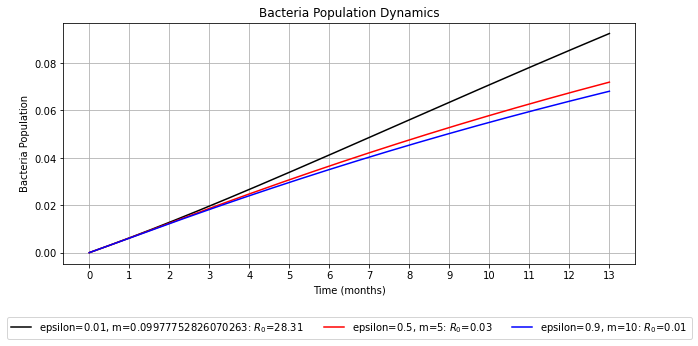

In [10]:
epsilon_values = [ 0.01,0.5,0.9]
m_values = [0.09977752826070263,5,10]
plot_bacteria_variation('epsilon', epsilon_values,'m', m_values)
#plt.savefig('BacteriaE', facecolor='w')

# For recovered populations

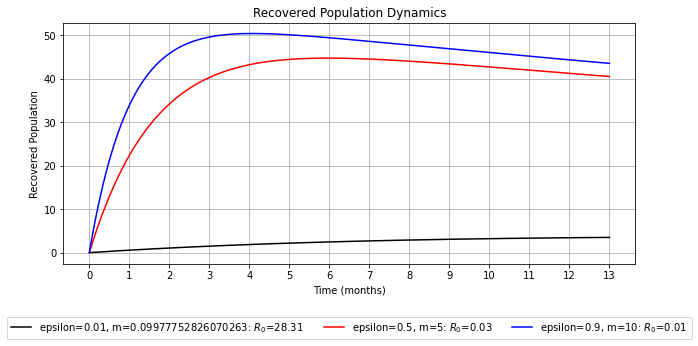

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Define the system of differential equations
def model(t, y, sigma, theta_h, theta_e, epsilon, nu, iota, omega, r1, k, psi, m):
    s, i, r, b = y
    dsdt = sigma - (theta_h * i / (m + i) + theta_e * b) * s - (epsilon + sigma) * s
    didt = (theta_h * i / (m + i) + theta_e * b) * s - (sigma + nu + iota + omega) * i
    drdt = iota * i + epsilon * s - sigma * r
    dbdt = omega * i + r1 * b - (r1 * b**2 / k) - psi * b
    return [dsdt, didt, drdt, dbdt]

# Initial conditions
s0 = 60
i0 = 50
r0 = 0
b0 = 0
initial_conditions = [s0, i0, r0, b0]

# Parameters
sigma = 0.019027976457235946
theta_h = 0.08868947739575793
theta_e = 0.05479866084983293
epsilon = 0.027175362133554693
omega = 0.00012021867374392852
r1 = 0.3006725563820228
psi = 0.3137292870148979
m = 0.09977752826070263
iota = 0.000116620
nu = 0.00132473
k = 1000000.0

# Define the function to calculate R_0
def calculate_R0(sigma, theta_h, theta_e, epsilon, nu, iota, omega, r1, psi, m):
    R_0 = (omega * theta_e * sigma) / ((nu + iota + omega + sigma) * (epsilon + sigma) * (psi - r1)) + \
          (theta_h * sigma) / ((nu + iota + omega + sigma) * (epsilon + sigma) * m)
    return R_0

R_0 = calculate_R0(sigma, theta_h, theta_e, epsilon, nu, iota, omega, r1, psi, m)

# Time span for the simulation
t_span = (0, 13)
t_eval = np.linspace(*t_span, 500)

# Function to solve the model and plot the results for recovered population
def plot_recovered_variation(param_name1, param_values1, param_name2, param_values2):
    fig, ax = plt.subplots(figsize=(10, 5))
    colors = ['black','red',  'blue']

    for param_value1, param_value2, color in zip(param_values1, param_values2, colors):
        params = [sigma, theta_h, theta_e, epsilon, nu, iota, omega, r1, k, psi, m]
        
        param_index1 = ['sigma', 'theta_h', 'theta_e', 'epsilon', 'nu', 'iota', 'omega', 'r1', 'k', 'psi', 'm'].index(param_name1)
        param_index2 = ['sigma', 'theta_h', 'theta_e', 'epsilon', 'nu', 'iota', 'omega', 'r1', 'k', 'psi', 'm'].index(param_name2)
        
        params[param_index1] = param_value1
        params[param_index2] = param_value2
        
        partial_params = params.copy()
        partial_params.pop(8)
        
        R_0 = calculate_R0(*partial_params)
        sol = solve_ivp(model, t_span, initial_conditions, t_eval=t_eval, args=tuple(params))
        
        label = f'{param_name1}={param_value1}, {param_name2}={param_value2}: $R_0$={np.round(R_0, 2)}'
        ax.plot(sol.t, sol.y[2], label=label, color=color)  # sol.y[2] is for recovered population
    
    ax.set_xlabel('Time (months)')
    ax.set_ylabel('Recovered Population')
    ax.set_title('Recovered Population Dynamics')
    #ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.legend(bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=len(param_values1))

    plt.grid(True)
    plt.tight_layout()
    plt.xticks(ticks=np.arange(0,14), labels=np.round(np.arange(0,14), 0))

    plt.show()
epsilon_values = [ 0.01,0.5,0.9]
m_values = [0.09977752826070263,5,10]
plot_recovered_variation('epsilon', epsilon_values,'m', m_values)
#plt.savefig('RecoveredE', facecolor='w')

# Change of m in each compartments.

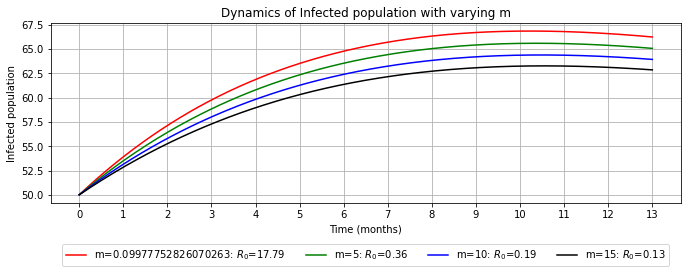

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Define the system of differential equations
def model(t, y, sigma, theta_h, theta_e, epsilon, nu, iota, omega, r1, k, psi, m):
    s, i, r, b = y
    dsdt = sigma - (theta_h * i / (m + i) + theta_e * b) * s - (epsilon + sigma) * s
    didt = (theta_h * i / (m + i) + theta_e * b) * s - (sigma + nu + iota + omega) * i
    drdt = iota * i + epsilon * s - sigma * r
    dbdt = omega * i + r1 * b - (r1 * b**2 / k) - psi * b
    return [dsdt, didt, drdt, dbdt]

# Initial conditions
s0 = 60
i0 = 50
r0 = 0
b0 = 0
initial_conditions = [s0, i0, r0, b0]

# Parameters
sigma = 0.019027976457235946
theta_h = 0.08868947739575793
theta_e = 0.05479866084983293
epsilon = 0.027175362133554693
omega = 0.00012021867374392852
r1 = 0.3006725563820228
psi = 0.3137292870148979
m = 0.09977752826070263
iota = 0.000116620
nu = 0.00132473
k = 1000000.0

# Define the function to calculate R_0
def calculate_R0(sigma, theta_h, theta_e, epsilon, nu, iota, omega, r1, psi, m):
    R_0 = (omega * theta_e * sigma) / ((nu + iota + omega + sigma) * (epsilon + sigma) * (psi - r1)) + \
          (theta_h * sigma) / ((nu + iota + omega + sigma) * (epsilon + sigma) * m)
    return R_0

R_0 = calculate_R0(sigma, theta_h, theta_e, epsilon, nu, iota, omega, r1, psi, m)
# print(f'R_0: {R_0}')

# Time span for the simulation
t_span = (0, 13)
t_eval = np.linspace(*t_span, 500)

# Function to solve the model and plot the results for the bacteria compartment
def plot_Infected_variation(param_name, param_values):
    variable_index = 1  # Index for bacteria
    variable_title = 'Infected population'
    colors = ['red', 'green', 'blue', 'black']  # Define colors for different parameter values

    plt.figure(figsize=(10, 4))
    
    for param_value, color in zip(param_values, colors):
        params = [sigma, theta_h, theta_e, epsilon, nu, iota, omega, r1, k, psi, m]
        param_index = ['sigma', 'theta_h', 'theta_e', 'epsilon', 'nu', 'iota', 'omega', 'r1', 'k', 'psi', 'm'].index(param_name)
        params[param_index] = param_value
        
        partial_params = params.copy()
        partial_params.pop(8)
        
        R_0 = calculate_R0(*partial_params)
        sol = solve_ivp(model, t_span, initial_conditions, t_eval=t_eval, args=tuple(params))
        
        plt.plot(sol.t, sol.y[variable_index], label=f'{param_name}={param_value}: $R_0$={np.round(R_0, 2)}', color=color)
    
    plt.xlabel('Time (months)')
    plt.ylabel(variable_title)
    plt.title(f'Dynamics of {variable_title} with varying {param_name}')
    plt.xticks(ticks=np.arange(0, 14), labels=np.round(np.arange(0, 14), 0))
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.legend(bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=len(param_values))

    plt.grid(True)
    plt.tight_layout()
    plt.xticks(ticks=np.arange(0,14), labels=np.round(np.arange(0,14), 0))
    plt.show()

# Example usage
param_name = 'm'
param_values =  [ 0.09977752826070263,5,10,15]
plot_Infected_variation(param_name, param_values)
#plt.savefig('Infected populations', facecolor='w')


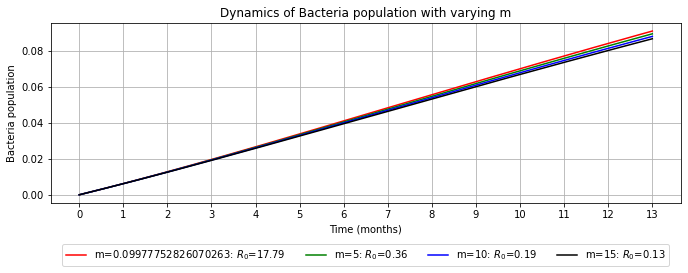

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Define the system of differential equations
def model(t, y, sigma, theta_h, theta_e, epsilon, nu, iota, omega, r1, k, psi, m):
    s, i, r, b = y
    dsdt = sigma - (theta_h * i / (m + i) + theta_e * b) * s - (epsilon + sigma) * s
    didt = (theta_h * i / (m + i) + theta_e * b) * s - (sigma + nu + iota + omega) * i
    drdt = iota * i + epsilon * s - sigma * r
    dbdt = omega * i + r1 * b - (r1 * b**2 / k) - psi * b
    return [dsdt, didt, drdt, dbdt]

# Initial conditions
s0 = 60
i0 = 50
r0 = 0
b0 = 0
initial_conditions = [s0, i0, r0, b0]

# Parameters
sigma = 0.019027976457235946
theta_h = 0.08868947739575793
theta_e = 0.05479866084983293
epsilon = 0.027175362133554693
omega = 0.00012021867374392852
r1 = 0.3006725563820228
psi = 0.3137292870148979
m = 0.09977752826070263
iota = 0.000116620
nu = 0.00132473
k = 1000000.0

# Define the function to calculate R_0
def calculate_R0(sigma, theta_h, theta_e, epsilon, nu, iota, omega, r1, psi, m):
    R_0 = (omega * theta_e * sigma) / ((nu + iota + omega + sigma) * (epsilon + sigma) * (psi - r1)) + \
          (theta_h * sigma) / ((nu + iota + omega + sigma) * (epsilon + sigma) * m)
    return R_0

R_0 = calculate_R0(sigma, theta_h, theta_e, epsilon, nu, iota, omega, r1, psi, m)
# print(f'R_0: {R_0}')

# Time span for the simulation
t_span = (0, 13)
t_eval = np.linspace(*t_span, 500)

# Function to solve the model and plot the results for the bacteria compartment
def plot_Bacteria_variation(param_name, param_values):
    variable_index = 3  # Index for bacteria
    variable_title = 'Bacteria population'
    colors = ['red', 'green', 'blue', 'black']  # Define colors for different parameter values

    plt.figure(figsize=(10, 4))
    
    for param_value, color in zip(param_values, colors):
        params = [sigma, theta_h, theta_e, epsilon, nu, iota, omega, r1, k, psi, m]
        param_index = ['sigma', 'theta_h', 'theta_e', 'epsilon', 'nu', 'iota', 'omega', 'r1', 'k', 'psi', 'm'].index(param_name)
        params[param_index] = param_value
        
        partial_params = params.copy()
        partial_params.pop(8)
        
        R_0 = calculate_R0(*partial_params)
        sol = solve_ivp(model, t_span, initial_conditions, t_eval=t_eval, args=tuple(params))
        
        plt.plot(sol.t, sol.y[variable_index], label=f'{param_name}={param_value}: $R_0$={np.round(R_0, 2)}', color=color)
    
    plt.xlabel('Time (months)')
    plt.ylabel(variable_title)
    plt.title(f'Dynamics of {variable_title} with varying {param_name}')
    plt.xticks(ticks=np.arange(0, 14), labels=np.round(np.arange(0, 14), 0))
    plt.legend(bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=len(param_values))

    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(ticks=np.arange(0,14), labels=np.round(np.arange(0,14), 0))

    plt.show()

# Example usage
param_name = 'm'
param_values =  [ 0.09977752826070263,5,10,15]
plot_Bacteria_variation(param_name, param_values)

#plt.savefig('Bacteria Population', facecolor='w')

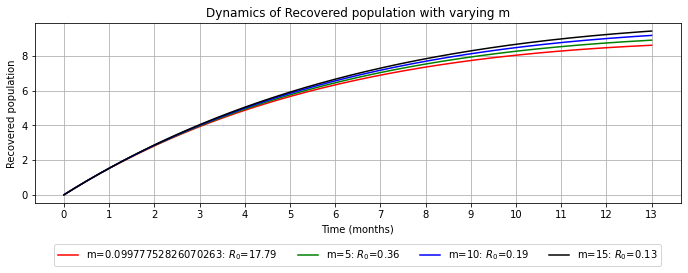

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Define the system of differential equations
def model(t, y, sigma, theta_h, theta_e, epsilon, nu, iota, omega, r1, k, psi, m):
    s, i, r, b = y
    dsdt = sigma - (theta_h * i / (m + i) + theta_e * b) * s - (epsilon + sigma) * s
    didt = (theta_h * i / (m + i) + theta_e * b) * s - (sigma + nu + iota + omega) * i
    drdt = iota * i + epsilon * s - sigma * r
    dbdt = omega * i + r1 * b - (r1 * b**2 / k) - psi * b
    return [dsdt, didt, drdt, dbdt]

# Initial conditions
s0 = 60
i0 = 50
r0 = 0
b0 = 0
initial_conditions = [s0, i0, r0, b0]

# Parameters
sigma = 0.019027976457235946
theta_h = 0.08868947739575793
theta_e = 0.05479866084983293
epsilon = 0.027175362133554693
omega = 0.00012021867374392852
r1 = 0.3006725563820228
psi = 0.3137292870148979
m = 0.09977752826070263
iota = 0.000116620
nu = 0.00132473
k = 1000000.0

# Define the function to calculate R_0
def calculate_R0(sigma, theta_h, theta_e, epsilon, nu, iota, omega, r1, psi, m):
    R_0 = (omega * theta_e * sigma) / ((nu + iota + omega + sigma) * (epsilon + sigma) * (psi - r1)) + \
          (theta_h * sigma) / ((nu + iota + omega + sigma) * (epsilon + sigma) * m)
    return R_0

R_0 = calculate_R0(sigma, theta_h, theta_e, epsilon, nu, iota, omega, r1, psi, m)
# print(f'R_0: {R_0}')

# Time span for the simulation
t_span = (0, 13)
t_eval = np.linspace(*t_span, 500)

# Function to solve the model and plot the results for the recovered population
def plot_Recovered_variation(param_name, param_values):
    variable_index = 2  # Index for recovered population
    variable_title = 'Recovered population'
    colors = ['red', 'green', 'blue', 'black']  # Define colors for different parameter values

    plt.figure(figsize=(10, 4))
    
    for param_value, color in zip(param_values, colors):
        params = [sigma, theta_h, theta_e, epsilon, nu, iota, omega, r1, k, psi, m]
        param_index = ['sigma', 'theta_h', 'theta_e', 'epsilon', 'nu', 'iota', 'omega', 'r1', 'k', 'psi', 'm'].index(param_name)
        params[param_index] = param_value
        
        partial_params = params.copy()
        partial_params.pop(8)
        
        R_0 = calculate_R0(*partial_params)
        sol = solve_ivp(model, t_span, initial_conditions, t_eval=t_eval, args=tuple(params))
        
        plt.plot(sol.t, sol.y[variable_index], label=f'{param_name}={param_value}: $R_0$={np.round(R_0, 2)}', color=color)
    
    plt.xlabel('Time (months)')
    plt.ylabel(variable_title)
    plt.title(f'Dynamics of {variable_title} with varying {param_name}')
    plt.legend(bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=len(param_values))
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(ticks=np.arange(0,14), labels=np.round(np.arange(0,14), 0))
    plt.show()

# Example usage
param_name = 'm'
param_values = [0.09977752826070263, 5, 10, 15]
plot_Recovered_variation(param_name, param_values)


#plt.savefig('Recovered Population', facecolor='w')